# Towards a Unified Theory of 80s Funk Charts
In another life, I made rap beats, and because it was another life, this involved finding records to sample, and because making rap beats did not make me a lot of money, this involved finding cheap records.

Rather than tracking down exactly what I wanted and paying market rate for it, I would scour thrift stores, garage sales, and record stores that didn't really know how to price their vinyl. A lot of the time I didn't have the luxury of listening before I copped, so I had to judge using whatever information I had. And so, like so many other broke record junkies, I developed a working knowledge of random musicians, producers, engineers and other music industry personnel whose involvement with a project would push me one way or the other.

For my capstone, I adapted this process of triangulating value from the names on the back of funk records from 1978 into an exercise in data science. But instead of deciding whether or not an album is worth three dollars or whatever, I opted for a more standardized metric: Billboard chart position.

My original vision for this project looked something like NLP, in which I would use a massive, sparse matrix with I originally planned to something like NLP, using a massive, sparse matrix with a row for each album and a feature for every combination of personnel and role, to predict an album's peak chart position. However, after that strategy failed, I ended up treating an album's journey down and up the charts as a time series.

## Two Important Notes
1) Since Billboard charts are numbered backwards, with #1 being the best and #50 being the bottom of the chart, explaining movement on the chart can be confusing.

**For this notebook, everything corresponds to absolute direction.**  
Negative movement 'down' the chart is good, while positive movement 'up' the chart is bad. So for example,  an album that moves from #6 to #2 has moved four places 'down' the chart, and its movement is -4.

2) Billboard metrics change with the music industry, which was a very different place in the late 70's and early 80's. I would be surprised if anything revelations found in this project would be particularly useful to predicting contemporary chart positions. I chose to do this project less because I had an interest in forecasting music sales, and more because the idea of my data including Luther Vandross cracks me up.

# Data Acquistion
Billboard has a thorough API with [an equally useful, albeit unofficial, Python wrapper](https://github.com/guoguo12/billboard-charts). This made acquiring the chart data rather straightforward. I wrote a suite of functions which automated all of my data collection and feature engineering.

### 'charto'
'charto' takes the name and date of a Billboard chart and, using the Billboard API, returns a chart object. The chart can be printed in full, but also indexed numerically into individual chart entries which, in turn, know their name, album title and chart position.

For the record, Billboard chart 'date' objects are 'YYYY-MM-DD' strings.

In [267]:
import pandas as pd
import numpy as np
import billboard
import datetime as datetime
import warnings
warnings.simplefilter("ignore")

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
    
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-pastel')

In [2]:
def charto(chart='r-b-hip-hop-albums', date='1984-01-22'):
    return billboard.ChartData(chart, date)

### 'date_o'
Since the charts are indexed weekly, not every date has an associated chart. The API automatically adjusted any date accordingly, but could be slow. Eventually I just made a big list of chart dates ('all_dates') and wrote this function to do the conversion locally.

In [3]:
all_dates = pd.read_csv('data_safe/all_dates.csv')

def date_o(d, dates='all_dates'):
    for n in dates:
        if n >= d:
            return n

### 'mega_track'
Given 'start' (a date formatted for Billboard), 'delta' (a number of days) and 'end' (a conditional statement about the stop date), 'mega_track' collects data from the charts over the specified time. After pulling the entries from the closest chart to 'start', it advances 'delta' days and continues reading data. 'Start' will automatically convert to a date with a Billboard chart.

'end' is a conditional statement about 'd1' (the internal date variable). So, setting 'end' to 'd1.year < 1980' means 'mega_track' would continue gathering data until it reached 1980. The function accesses the 'R&B and Hip-Hop Albums' chart by default, but will scrape any chart passed as 'chart_name'. Setting the 'track' variable to True turns on print calls within the function that allow progress tracking.

On its first pass, 'mega_track' collects 'artist', 'title', chart 'position' and 'chart_date', then automatically creates the 'key' column: 'artist' and 'title' joined with '-' to make a universal index.

After pulling all the data from the specified range, 'mega_track' adds a feature for the number of 'weeks_on_chart', as well as three lag columns for chart position. 'lag_1' and 'lag_2' track the album's position in the previous chart and the chart before that respectively, while 'next_pos' is where the album will be on the next chart. The null values created by the lag columns are then filled in with '51', a value representing no longer charting.

(While 'delta' can be set while calling the function, it defaults to 7 and charts are assumed to be consecutive.)

Next, 'mega_track' calculates the movement between weeks: 'next_delta' is between the current week and next week, 'delta_1' between last week and the current week, and 'delta_2' between the previous two weeks. (These values are the later week subtracted from the earlier week.)

The function adds 'move' columns will which become the targets for modeling. 'move' is 1 if the album moves next week and 0 if it doesn't. 'move_2' is 'stay' if the album doesn't move, 'down' if the position goes down and 'up' if not. 'move_2n' is a numerical version of 'move_2', replacing 'down', 'stay' and 'up' with -1, 0 and 1 respectively.

Finally, it creates 'debut' and 'year', the first time the album shows up on the charts and the current year for every entry. (These are mostly for future engineering.)

In [73]:
def mega_track(start, delta, end, chart_name='r-b-hip-hop-albums', track=False):
    d1 = datetime.datetime.strptime(start, '%Y-%m-%d')
    dd = datetime.timedelta(days=delta)

    mega = pd.DataFrame(columns=['artist', 'title', 'chart_date', 'position'])

    # while 'end' is true...
    while eval(end):

        # read d0
        d0 = d1.strftime('%Y-%m-%d')
        print(d0)

        chart = charto(chart_name, d0)
        c_dict = {'artist':[],'title':[],'position':[]}
        for c in chart:
            c_dict['artist'].append(c.artist)
            c_dict['title'].append(c.title)
            c_dict['position'].append(c.rank)

        df = pd.DataFrame(c_dict)

        # add 'chart_date' column to 'df' with all entries equal to d0
        df['chart_date'] = chart.date

        # add 'df' to 'mega'
        mega = pd.concat([mega, df])
        d1 += dd

    mega2 = pd.DataFrame(columns=['artist', 'title', 'key', 'chart_date', 'position', 'weeks_on_chart'])

    # add 'weeks' on chart
    mega['key'] = mega[['artist','title']].apply(lambda x: ' - '.join(x), axis=1)
    for k in mega['key'].unique():
        df = mega[mega['key'] == k]
        df = df.reset_index(drop=True).reset_index().rename(columns={'index':'weeks_on_chart'})
        df['lag_1'] = df['position'].shift()
        df['lag_2'] = df['position'].shift(2)
        df['next_pos'] = df['position'].shift(-1)
        df.fillna('51', inplace=True)

        # add 'total_weeks' and 'peak' columns
        df['peak'] = df['position'].min()
        df['total_weeks'] = df['weeks_on_chart'].max()

        mega2 = pd.concat([mega2, df])

    # convert columns to numerical if possible
    for c in mega2.columns:
        try:
            mega2[c] = pd.to_numeric(mega2[c])
        except ValueError:
            continue

    # add 'delta' columns and 'move'
    mega2['next_delta'] = mega2['next_pos'] - mega2['position']
    mega2['delta_1'] = mega2['position'] - mega2['lag_1']
    mega2['delta_2'] = mega2['lag_1'] - mega2['lag_2']
    mega2['move'] = mega2['next_delta'].map(lambda x: 0 if x == 0 else 1)
    mega2['move_2'] = mega2['next_delta'].map(lambda x: 'up' if x > 0 else ('stay' if x == 0 else 'down'))
    mega2['move_2n'] = mega2['move_2'].map(lambda x: 1 if x == 'up' else (0 if x == 'stay' else -1))

    # add 'debut'
    mega3 = pd.DataFrame(columns=mega2.columns)
    for k in mega2['key'].unique():
        if track:
            print(k)
        df = mega2[mega2['key'] == k].sort_values('chart_date')
        df['debut'] = df.head(1)['chart_date'].values[0]
        mega3 = pd.concat([mega3, mega2])
        
    # add 'year'
    mega3['year'] = mega3['chart_date'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').year)

    return mega3.reset_index(drop=True)

### 'album_track'
This function takes the output of 'mega_track' and, for every album, tacks on the peak position and number of weeks on the chart for the last album by that artist. These features are meant to contextualizes the albums while modeling.

In [4]:
def album_track(mt, track=False):
    mt_cull = mt[[
        'key','artist','title','peak','total_weeks','debut']].drop_duplicates().sort_values(['artist','debut'])
    mt2 = pd.DataFrame(columns=['artist'])
    for a in mt_cull['artist'].unique():
        if track:
            print(a)
        df = mt_cull[mt_cull['artist'] == a]
        df['peak_lag'] = df['peak'].shift()
        df['weeks_lag'] = df['total_weeks'].shift()
        mt2 = pd.concat([mt2, df])
    if track:
        print('adding lags')
    mt2['peak_lag'] = mt2['peak_lag'].fillna(51)
    mt2['weeks_lag'] = mt2['weeks_lag'].fillna(0)

    # merge with 'mega_track'
    mt3 = pd.merge(mt, mt2[['key','weeks_lag', 'peak_lag']], on='key')

    # convert columns to numerical if possible
    for c in mt3.columns:
        try:
            mt3[c] = pd.to_numeric(mt3[c])
        except ValueError:
            continue

    return mt3

# A Look At The Data
My data is the 'R&B and Hip-Hop' charts from 1975 to 1985, although I scraped a wider range than that to give the albums at either end of the window the proper values. (Otherwise my data would say every album charting on 1/1/1975 debuted that week, for example.) When all is said and done, I have 28673 entries for 2020 albums by 691 artists.


In [13]:
# importing a saved version of the data
df = pd.read_csv('data_safe/df_at_for_models_714.csv').drop('Unnamed: 0', axis=1)

As one would expect, distribution of chart positions is uniform.

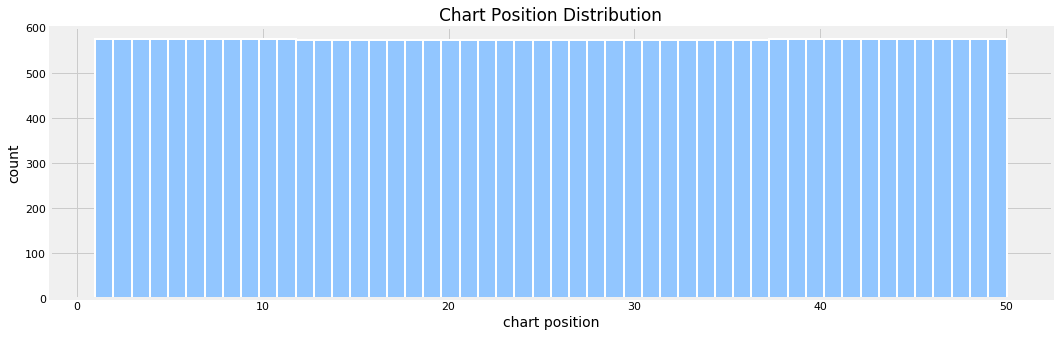

In [239]:
plt.tight_layout()
df['position'].hist(figsize=(16,5), ec='w', lw=2, width=1, bins=50)
plt.title(s='Chart Position Distribution', size=17)
plt.xticks(size=11)
plt.yticks(size=11)
plt.xlabel(s='chart position', size=14)
plt.ylabel(s='count', size=14);

# Some Observations About Chart Movement
### Chart position are reasonably predictable.
Every album follows a parabolic path, starting high, descending, stabilizing, then reversing course until they are off the chart.

However, the speed at which any of these steps happens is the variable: a highly anticipated album could hit \#1 from the jump and stay there for weeks, while a breakout album slowly gaining traction could take months before it reaches its peak.

In [246]:
def chart_path(artist, cols, x, y, i=None):
    if i is None:
        keys = df[df['artist']==artist]['key'].unique()
    else:
        keys = [df[df['artist']==artist]['key'].unique()[x] for x in i]
    plots = len(keys)
    rows = int(plots/cols) + (plots % cols)
    n = 1
    fig = plt.figure(figsize=(x,y))
    plt.tight_layout()
    for k in keys:
        d = df[df['key'] == k]
        t = d['title'].values[0]
        yr = d['year'].values[0]
        plt.subplot(rows, cols, n)
        plt.scatter('weeks_on_chart', 'position', data=d, alpha=1, color='orange', edgecolor='blue')
        plt.plot('weeks_on_chart', 'position', data=d, linewidth=2)
        plt.title(s=f'{t}, {yr}', size=x)
        plt.xlabel(s='Weeks On Chart', size=11)
        plt.ylabel(s='Chart Position', size=11)
        plt.xticks(size=9)
        plt.yticks(size=9)
        plt.ylim(0,50)
        n += 1

As shown below, Chic's self-titled 1978 debut took 7 weeks to climb from \#45 its peak at \#12. Its took almost 3 more months before it was off the charts. Chic's sophomore album, "C'est Chic", debuted at \#3, hit \#1 the next week and stayed on top of the chart for another 3 months. But even though it was more successful, "C'est Chic" charted for 4 fewer weeks.

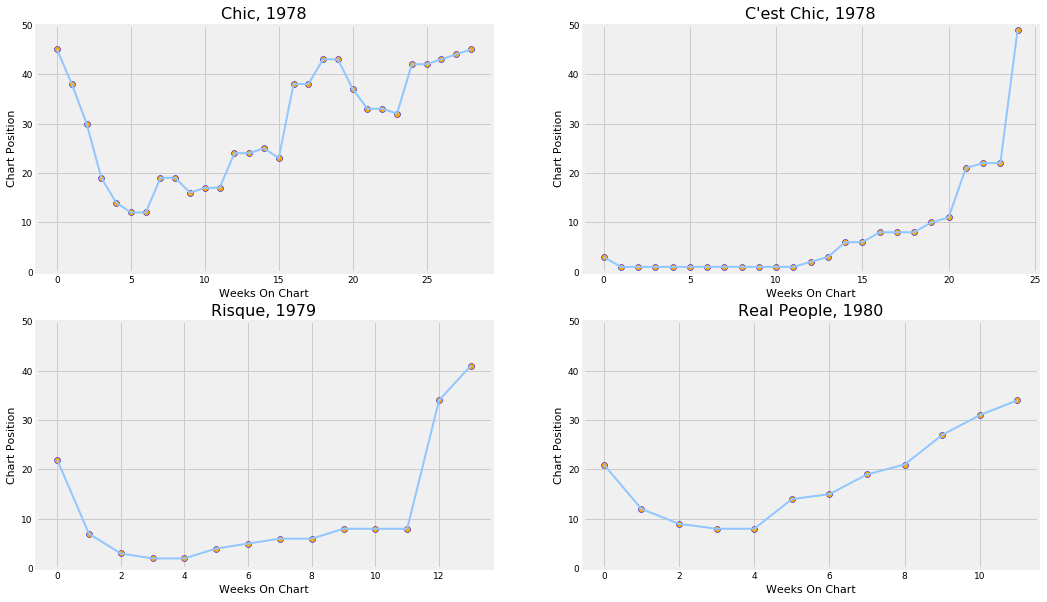

In [247]:
chart_path('Chic', 2, 16, 10, [0,1,2,4])

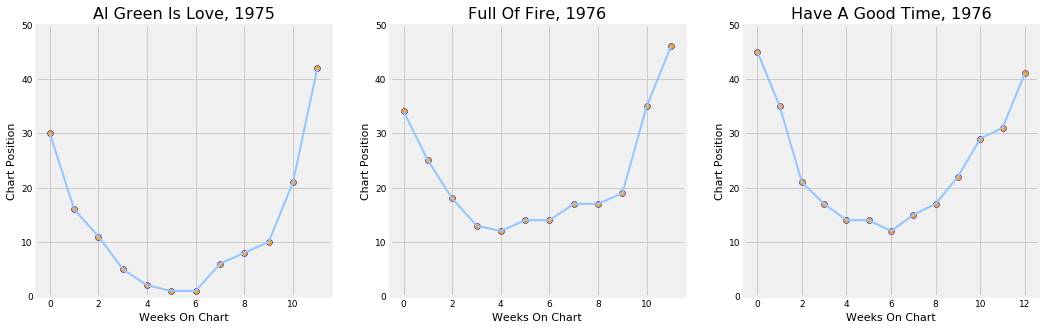

In [330]:
chart_path('Al Green', 3, 16, 5, [2,3,4])

### Chart Movement Is Slow
It's rare for an album to jump more than a handful of positions from week to week. As shown on the distributions of the three features measuring chart to chart change, the vast majority of the values are below 5.

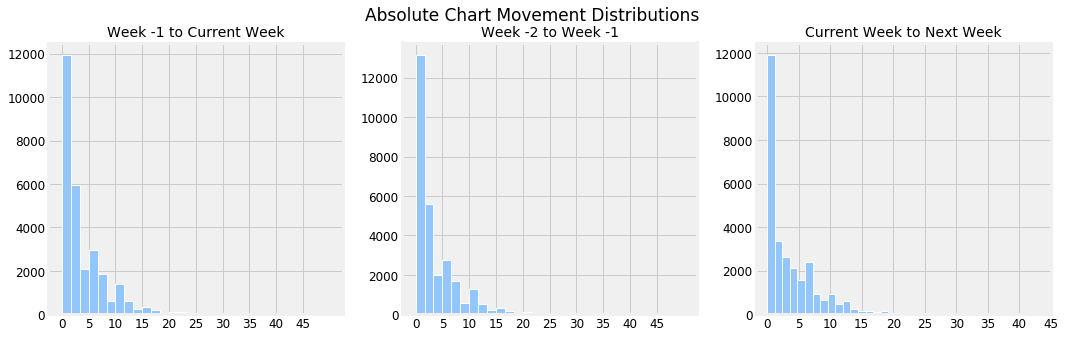

In [257]:
plt.figure(figsize=(16,5))
# plt.tight_layout(h_pad=2)
plt.suptitle(t='Absolute Chart Movement Distributions',size=17)

# plot 1 
plt.subplot(1,3,1)
abs(df['delta_1']).hist(ec='w', lw=1, bins=30)
plt.title(s='Week -1 to Current Week', size=14)
plt.xticks(np.arange(0,50,5),size=12)
plt.yticks(size=12)


# plot 2
plt.subplot(1,3,2)
abs(df['delta_2']).hist(ec='w', lw=1, bins=30)
plt.title(s='Week -2 to Week -1', size=14)
plt.xticks(np.arange(0,50,5),size=12)
plt.yticks(size=12)

# plot 3
plt.subplot(1,3,3)
abs(df['next_delta']).hist(ec='w', lw=1, bins=30)
plt.title(s='Current Week to Next Week', size=14)
plt.xticks(np.arange(0,50,5),size=12)
plt.yticks(size=12);

### Albums Have Momentum
An album moving in one direction tends to stay moving in that direction. As shown on the plots below, the size and direction of the movement in consecutive weeks are correlated.

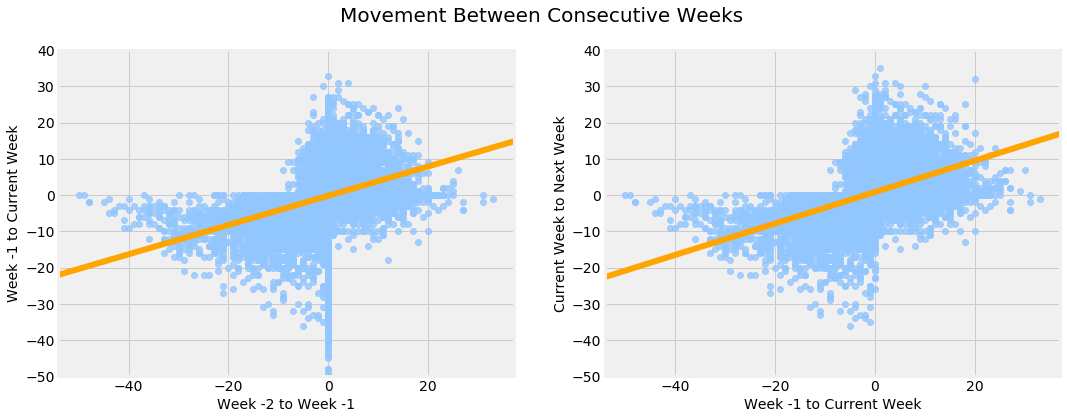

In [322]:
fig = plt.figure(figsize=(16,6))
plt.suptitle(t='Movement Between Consecutive Weeks', size=20)

# plot 1
plt.subplot(1,2,1)
sns.regplot(data=df, x='delta_2', y='delta_1', line_kws={'color':'orange'})
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Week -2 to Week -1', size=14)
plt.ylabel(s='Week -1 to Current Week', size=14)
plt.ylim(-50,40)

# plot 2
plt.subplot(1,2,2)
sns.regplot(data=df, x='delta_1', y='next_delta', line_kws={'color':'orange'})
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Week -1 to Current Week', size=14)
plt.ylabel(s='Current Week to Next Week', size=14)
plt.ylim(-50,40);

But while previous movement is a fairly good predictor of where an album will go next, it's not perfect. As shown below, previous movement only predicts next movement about half the time.

In [44]:
move_1 = df['delta_1'].map(lambda x: 'up' if x > 0 else ('stay' if x == 0 else 'down'))
move_0 = df['delta_2'].map(lambda x: 'up' if x > 0 else ('stay' if x == 0 else 'down'))
L = len(df)

print('% Identical Motion from Week -2 to Week -1 and Week -1 to Current Week:')
print((move_0 == move_1).sum()/L)
print('')

print('% Identical Motion from Week -1 to Current Week and Current Week to Next Week:')
print((move_1 == df['move_2']).sum()/L)

% Identical Motion from Week -2 to Week -1 and Week -1 to Current Week:
0.496355456353

% Identical Motion from Week -1 to Current Week and Current Week to Next Week:
0.539636591916


# Other Features
The new features added to the model are intended to better contextualize the album's chart performance, thus aiding it in predicting whether it will move and in which direction.

For example, as an album stays on the charts, it becomes less likely to move, and more likely to move upward if it does move.

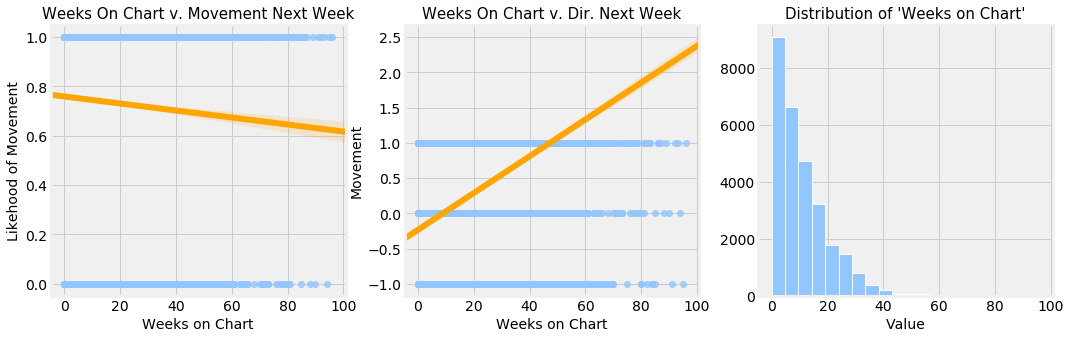

In [212]:
df['move_2n'] = df['move_2'].map(lambda x: 0 if x == 'stay' else (1 if x == 'up' else -1))
plt.figure(figsize=(16,5))
plt.tight_layout()

# weeks on chart v. movement (binary)
plt.subplot(1,3,1)
sns.regplot(data=df, x='weeks_on_chart', y='move', fit_reg=False)
sns.regplot(data=df, x='weeks_on_chart', y='move', scatter=False, color='orange')
plt.title(s='Weeks On Chart v. Movement Next Week', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Weeks on Chart', size=14)
plt.ylabel(s='Likehood of Movement', size=14)

# weeks on chart v. directional movement
plt.subplot(1,3,2)
sns.regplot(data=df, x='weeks_on_chart', y='move_2n', fit_reg=False)
sns.regplot(data=df, x='weeks_on_chart', y='move_2n', scatter=False, color='orange')
plt.title(s='Weeks On Chart v. Dir. Next Week', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Weeks on Chart', size=14)
plt.ylabel(s='Movement', size=14)

# distribution of weeks on chart
plt.subplot(1,3,3)
df['weeks_on_chart'].hist(ec='w', lw=1, bins=20)
plt.title(s='Distribution of \'Weeks on Chart\'', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Value', size=14);

And while worse-charting albums are more likely to move, it's tough to say which direction they will go.

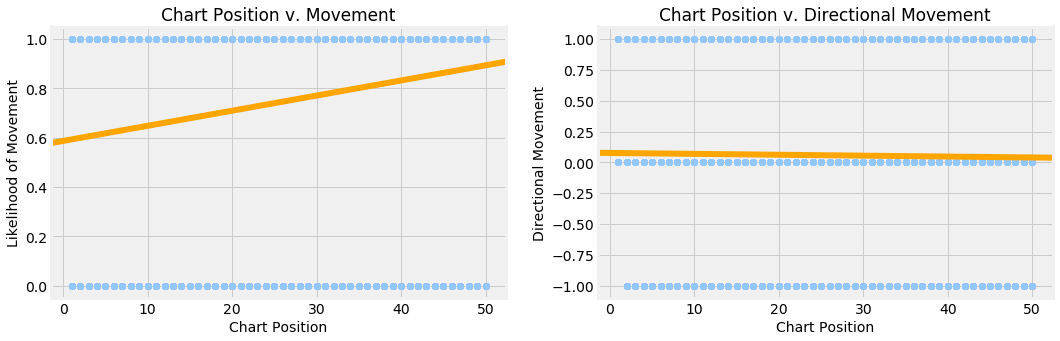

In [213]:
plt.figure(figsize=(16,5))
plt.tight_layout()

# chart position v. movement
plt.subplot(1,3,1)
sns.regplot(data=df, x='position', y='move', fit_reg=False)
sns.regplot(data=df, x='position', y='move', scatter=False, color='orange')
plt.title(s='Chart Position v. Movement', size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Chart Position', size=14)
plt.ylabel(s='Likelihood of Movement', size=14)

# chart position v. directional movement
plt.subplot(1,3,2)
sns.regplot(data=df, x='position', y='move_2n', fit_reg=False)
sns.regplot(data=df, x='position', y='move_2n', scatter=False, color='orange')
plt.title(s='Chart Position v. Directional Movement', size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Chart Position', size=14)
plt.ylabel(s='Directional Movement', size=14);

I also included the length of time the artist's last album stayed on the charts and its peak position as a way of contextualizing their popularity.

The longer an artist's last album charted, the less likely it is to move week to week, and slightly more likely to move up.

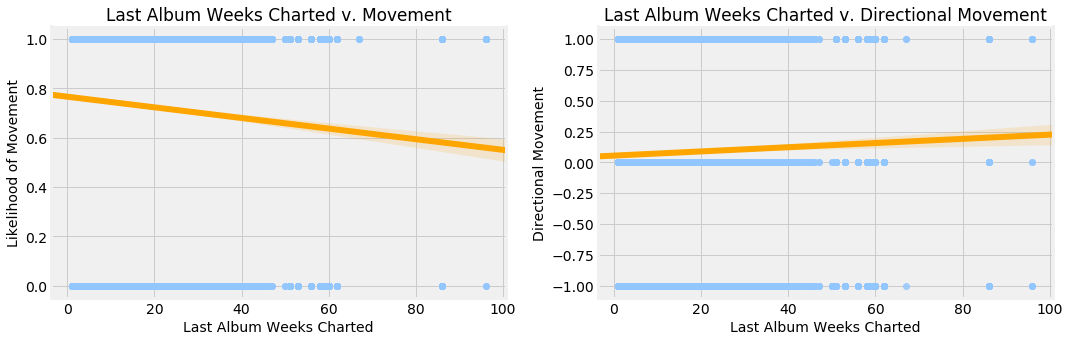

In [338]:
plt.figure(figsize=(16,5))
plt.tight_layout()

# subsetting for artists with a previous album
d = df[df['weeks_lag'] > 0]

# week_lag v. movement
plt.subplot(1,2,1)
sns.regplot(data=d, x='weeks_lag', y='move', fit_reg=False)
sns.regplot(data=d, x='weeks_lag', y='move', scatter=False, color='orange')
plt.title(s='Last Album Weeks Charted v. Movement', size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Last Album Weeks Charted', size=14)
plt.ylabel(s='Likelihood of Movement', size=14)

# week_lag v. directional movement
plt.subplot(1,2,2)
sns.regplot(data=d, x='weeks_lag', y='move_2n', fit_reg=False)
sns.regplot(data=d, x='weeks_lag', y='move_2n', scatter=False, color='orange')
plt.title(s='Last Album Weeks Charted v. Directional Movement', size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Last Album Weeks Charted', size=14)
plt.ylabel(s='Directional Movement', size=14);

The peak chart position of an artist's last album depresses its chance of movement slightly, and has a mild effect on direction of movement as well.

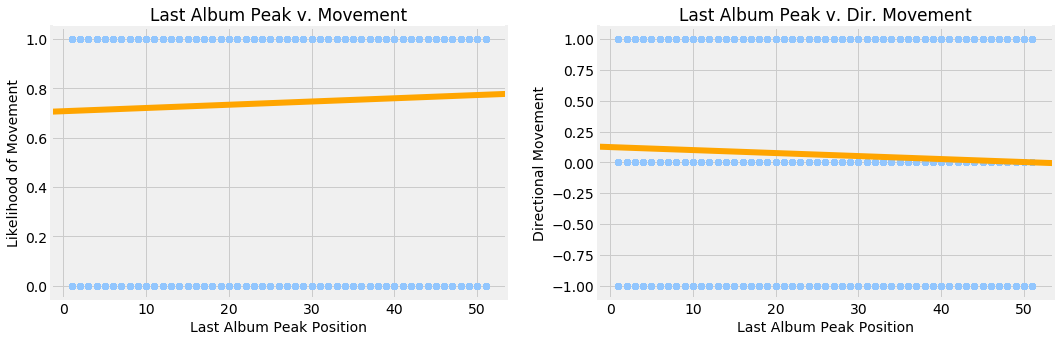

In [339]:
plt.figure(figsize=(16,5))
plt.tight_layout()

# subsetting for artists with a previous album
d = df[df['peak_lag'] != 51]

# peak_lag v. movement
plt.subplot(1,2,1)
sns.regplot(data=df, x='peak_lag', y='move', fit_reg=False)
sns.regplot(data=df, x='peak_lag', y='move', scatter=False, color='orange')
plt.title(s='Last Album Peak v. Movement', size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Last Album Peak Position', size=14)
plt.ylabel(s='Likelihood of Movement', size=14)

# week_lag v. directional movement
plt.subplot(1,2,2)
sns.regplot(data=df, x='peak_lag', y='move_2n', fit_reg=False)
sns.regplot(data=df, x='peak_lag', y='move_2n', scatter=False, color='orange')
plt.title(s='Last Album Peak v. Dir. Movement', size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(s='Last Album Peak Position', size=14)
plt.ylabel(s='Directional Movement', size=14);

# Modeling

Models used the following features:

name | data
:---|:---
 **position**| chart position on that date
 **delta_1**| movement between last chart and this chart
 **delta_2**| movement between two charts ago and last chart
 **weeks_on_chart**| how many consecutive weeks the album has charted
 **peak_lag**| peak chart position of artist's previous album
 **weeks_lag**| how many consecutive weeks the artist's previous album charted
 
 Depending on the goal, models used one of these two features:
 
 name | data
:---|:---
 **move**| binary: 0 for no movement, 1 for movement
 **move_2n**| -1 for downward movement, 0 for no movement, 1 for upward movement

I used four classification algorithms:
- Random Forest Classifier (from sci-kit learn)
- XGBoost Classifier
- K-Nearest Neighbors Classifider (from sci-kit learn)
- Stochastic Descent Gradient Classifier (from sci-kit learn)

### Distribution of Target Classes

In [346]:
df.move_2n.value_counts(normalize=True).to_frame().rename(columns={'move_2':'Frequency in Target Data'})

,move_2n
1,0.400621
-1,0.342761
0,0.256618


'1', representing upward chart movement, makes up about 40% of the target class. That is our baseline accuracy for classification.

In [104]:
# import saved scores
scores = pd.read_csv('data_safe/all_scores_diverse_models.csv')

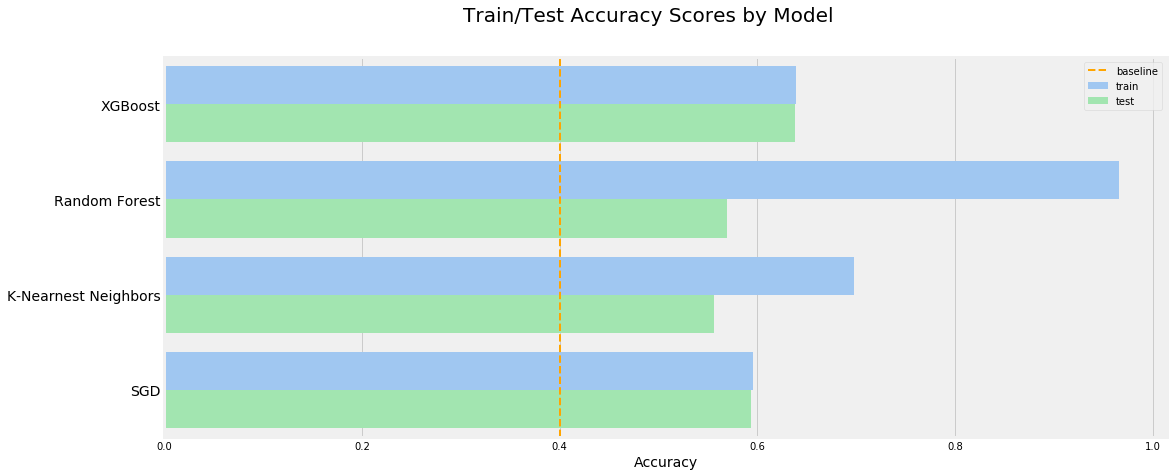

In [222]:
d = scores.loc[0:3].melt(id_vars='model',
                               value_vars=['train','test'],
                               var_name='data',
                               value_name='accuracy').sort_values('data', ascending=False)

fig = plt.figure(figsize=(16,7))
plt.suptitle(t='Train/Test Accuracy Scores by Model', size=20)

sns.barplot(data=d, y='model', x='accuracy', hue='data', ci=None)
plt.axvline(x=0.4, color='orange', linestyle='--', linewidth=2)
plt.yticks(np.arange(4), ['XGBoost', 'Random Forest', 'K-Nearnest Neighbors', 'SGD'], size=14)
plt.xlabel(s='Accuracy', size=14)
plt.ylabel(s='')
plt.legend(labels=['baseline','train','test']);

All four models are more accurate than the baseline. But how well do they predict the individual outcomes?

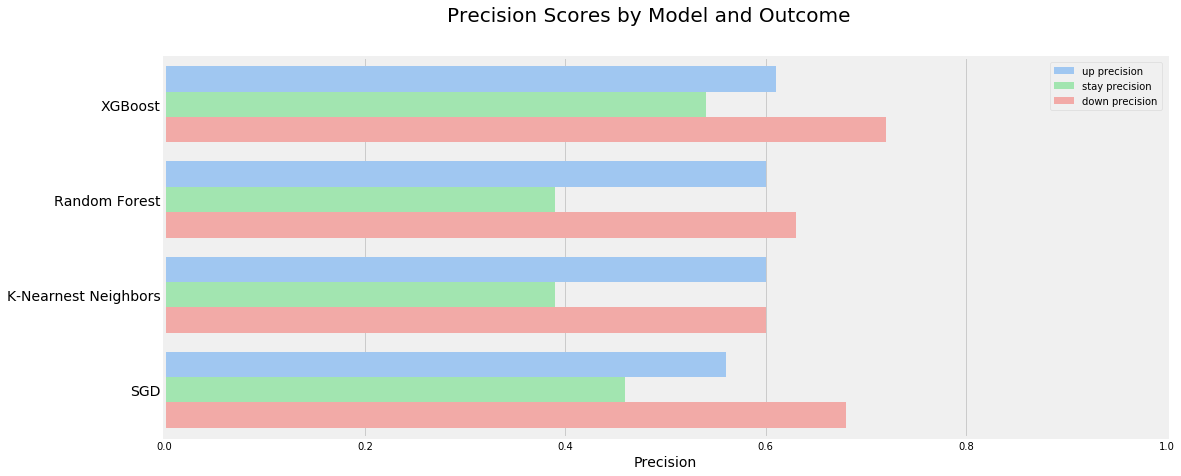

In [260]:
d = scores.loc[0:3].melt(id_vars='model',
                               value_vars=[c for c in scores.columns if 'precision' in c],
                               var_name='metric',
                               value_name='score').sort_values('metric', ascending=False)

fig = plt.figure(figsize=(16,7))
plt.suptitle(t='Precision Scores by Model and Outcome', size=20)

sns.barplot(data=d, y='model', x='score', hue='metric', ci=None)
plt.yticks(np.arange(4), ['XGBoost', 'Random Forest', 'K-Nearnest Neighbors', 'SGD'], size=14)
plt.xlabel(s='Precision', size=14)
plt.ylabel(s='')
plt.xlim(0,1)
plt.legend();

Rather than predicting all three outcomes at a consistant rate, the models are far better at predicting direction than whether an album will move.

Across all the models, recall for 'stay' (no movement) is substantially lower than for the other two categories. This indicates a lot of false negatives.

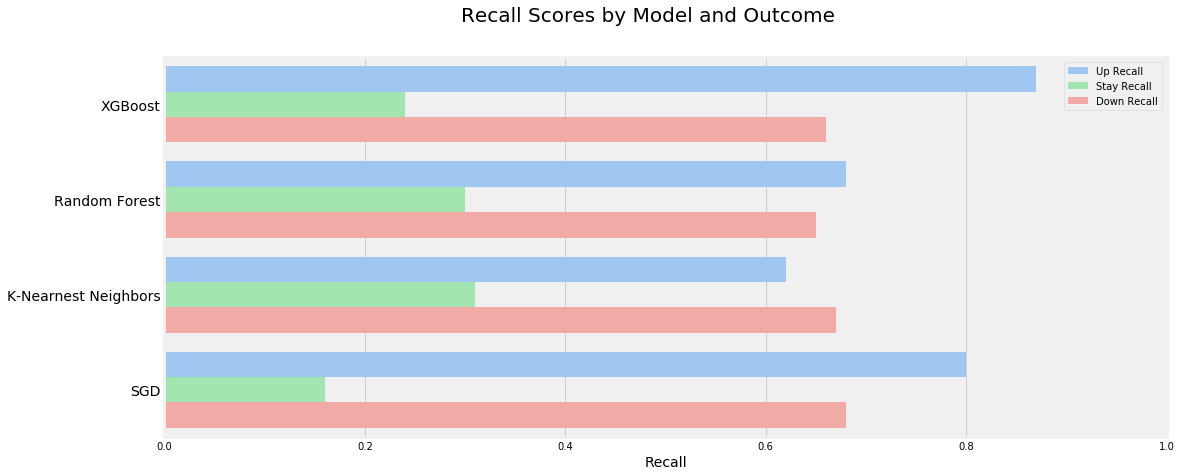

In [227]:
d = scores.loc[0:3].melt(id_vars='model',
                               value_vars=[c for c in scores.columns if 'recall' in c],
                               var_name='metric',
                               value_name='score').sort_values('metric', ascending=False)

fig = plt.figure(figsize=(16,7))
plt.suptitle(t='Recall Scores by Model and Outcome', size=20)

sns.barplot(data=d, y='model', x='score', hue='metric', ci=None)
plt.yticks(np.arange(4), ['XGBoost', 'Random Forest', 'K-Nearnest Neighbors', 'SGD'], size=14)
plt.xlabel(s='Recall', size=14)
plt.ylabel(s='')
plt.xlim(0,1)
plt.legend(labels=['Up Recall','Stay Recall','Down Recall']);

### Predicting Movement v. Predicting Direction
To verify this trend, here's the same models predicting only whether an album will or will not move.

Since the ratio of 'move' to 'stay' is about 3:1 in the data, I transformed my training set with the [imbalanced learn SMOTE](http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.over_sampling.SMOTE.html) package to simulate a better class balance and (hopefully) get better results. Even so, none of the algorithms beat the baseline accuracy, and all show disappointing recall.

(While SGD does have a high recall for 'stay', it has the lowest values for all other metrics. It's doing something different, but it's still not good.)

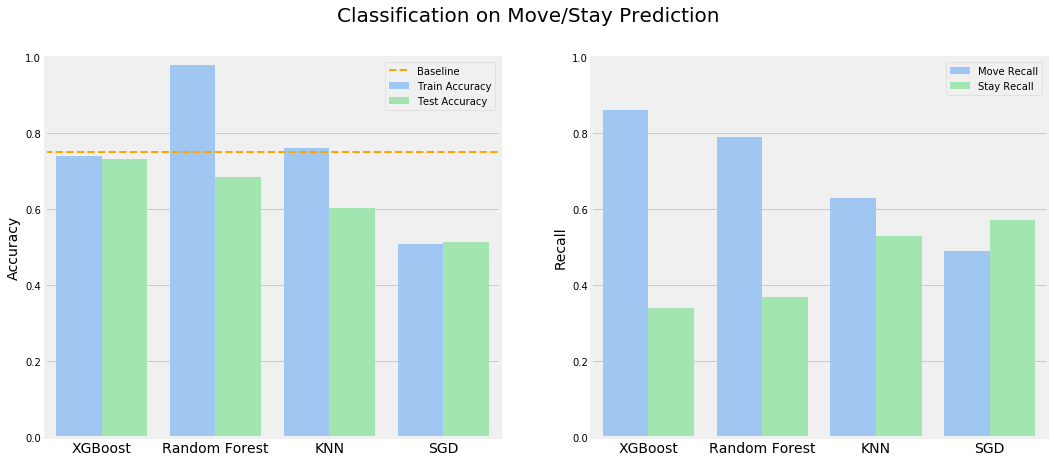

In [231]:
fig = plt.figure(figsize=(16,7))
plt.suptitle(t='Classification on Move/Stay Prediction', size=20)

# accuracy plot
plt.subplot(1,2,1)
d = scores.loc[4:7].melt(id_vars='model',
                               value_vars=['train','test'],
                               var_name='data',
                               value_name='accuracy').sort_values('data', ascending=False)

ax = sns.barplot(data=d, x='model', y='accuracy', hue='data', ci=None)
plt.axhline(y=0.75, color='orange', linestyle='--', linewidth=2)
plt.xticks(np.arange(4), ['XGBoost', 'Random Forest', 'KNN', 'SGD'], ha='center', size=14)
plt.xlabel(s='')
plt.ylabel(s='Accuracy', size=14)
plt.ylim(0,1)
ax.legend(labels=['Baseline','Train Accuracy','Test Accuracy']);

# recall plot
plt.subplot(1,2,2)
d = scores.loc[4:7].melt(id_vars='model',
                               value_vars=['up recall', 'stay recall'],
                               var_name='metric',
                               value_name='score').sort_values('metric', ascending=False)

ax = sns.barplot(data=d, x='model', y='score', hue='metric', ci=None)
plt.xticks(np.arange(4), ['XGBoost', 'Random Forest', 'KNN', 'SGD'], ha='center', size=14)
plt.xlabel(s='')
plt.ylabel(s='Recall', size=14)
plt.ylim(0,1)
ax.legend(labels=['Move Recall','Stay Recall']);

On the other hand, the model predicts movement direction fairly well when only given a subset of the data that moves. Accuracy clears baseline and recall scores jump up to around 0.7.

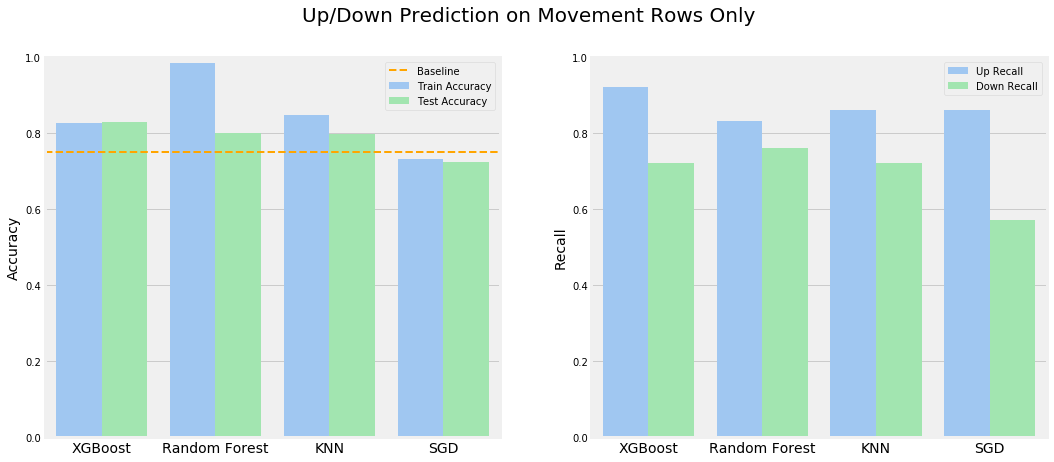

In [236]:
fig = plt.figure(figsize=(16,7))
plt.suptitle(t='Up/Down Prediction on Movement Rows Only', size=20)

plt.subplot(1,2,1)
d = scores.loc[8:11].melt(id_vars='model',
                               value_vars=['train','test'],
                               var_name='data',
                               value_name='accuracy').sort_values('data', ascending=False)

sns.barplot(data=d, x='model', y='accuracy', hue='data', ci=None)
plt.axhline(y=0.75, color='orange', linestyle='--', linewidth=2)
plt.xticks(np.arange(4), ['XGBoost', 'Random Forest', 'KNN', 'SGD'], ha='center', size=14)
plt.xlabel(s='')
plt.ylabel(s='Accuracy', size=14)
plt.legend(labels=['Baseline','Train Accuracy','Test Accuracy']);
plt.ylim(0,1);

plt.subplot(1,2,2)
d = scores.loc[8:11].melt(id_vars='model',
                               value_vars=['up recall', 'down recall'],
                               var_name='metric',
                               value_name='score').sort_values('metric', ascending=False)

sns.barplot(data=d, x='model', y='score', hue='metric', ci=None)
plt.xticks(np.arange(4), ['XGBoost', 'Random Forest', 'KNN', 'SGD'], ha='center', size=14)
plt.xlabel(s='')
plt.ylabel(s='Recall', size=14)
plt.legend(labels=['Up Recall','Down Recall']);
plt.ylim(0,1);

# 2 Problems In One
It's clear from the results of these models that I made a fundamental misintreptation of the data. Whether an album's chart position changes from week to week is an entirely different question than which direction it will move if it does.

My model sought to answer two questions at once. Not surprisingly, it answers neither reliably.

# Next Steps
There is a way to duck the entire issue of figuring out whether or not an album will move. Rather than striving to predict definitively what will happen on the next chart with classification algorithsm, I could use regression to quantify what the data says will happen with a little more nuance. The challenge then would be interpreting that number.

More generally, I could improve the model with more data. The easy improvement would be to add more lag features in addition to the two weeks I used. But my original idea was to bring cultural and artistic context to the project with features based on the album personnel. I'm still disappointed I couldn't make that work.